In [1126]:
import numpy as np
import pandas as pd
import os
import pytz

import time
import datetime
import glob

import warnings
warnings.filterwarnings("ignore")

from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 100
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.tree import plot_tree
from matplotlib.gridspec import GridSpec
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import seaborn as sns
from scipy.stats import spearmanr
# Upload the results to the spreadsheet
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

import google.auth
from googleapiclient.http import MediaFileUpload



# If modifying these scopes, delete the file token.json.
SCOPES = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive.file"]

# The ID and range of a sample spreadsheet.
SPREADSHEET_ID = "1hLxwornAd9DzDklNHmnypfi3t9Y9oRRJp3tGIwXHT94"
# SAMPLE_RANGE_NAME = "Overall!E1"

np.random.seed(0)

In [1127]:
creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists("token.json"):
  creds = Credentials.from_authorized_user_file("token.json", SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
  if creds and creds.expired and creds.refresh_token:
    creds.refresh(Request())
  else:
    flow = InstalledAppFlow.from_client_secrets_file(
        "credentials.json", SCOPES
    )
    creds = flow.run_local_server(port=0)
  # Save the credentials for the next run
  with open("token.json", "w") as token:
    token.write(creds.to_json())

In [1128]:
# convert number to A-Z numbering format
# 1 - A, 2 - B, ..., 26 - Z, 27 - AA, 28 - AB
def az_convert(column_int):
    start_index = 1
    letter = ''
    while column_int > 25 + start_index:   
        letter += chr(65 + int((column_int-start_index)/26) - 1)
        column_int = column_int - (int((column_int-start_index)/26))*26
    letter += chr(65 - start_index + (int(column_int)))
    return letter

In [1129]:
# get next column available in sheets
try:
    service = build("sheets", "v4", credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = (
        sheet.values()
        .get(spreadsheetId=SPREADSHEET_ID, range="Overall!1:1")
        .execute()
    )
    values = result.get("values", [])
    next_row = az_convert(len(values[0])+1)
    print(next_row)
except HttpError as err:
    print(err)

EB


In [1130]:
# Load data
df = pd.read_csv('/home/lumi/Git/money-repo/Model_Testing/Data_Simple_Returns_90x240.csv')
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].dt.date
df.drop(['Hour of Day '], axis = 1, inplace=True)

In [1131]:
df.head()

,Time,Previous 90 Minute Return (Input),Bucket 1 (-100 - -.80%) Prev 90 minute return,Bucket 2 (-.8% - -.4%) Prev 90 minute return,Bucket 3 (-.40% - -.1%),Bucket 4 (-.1% - .1%),Bucket 5 (.1% - 0.40%) Prev 90 minute return,Bucket 6 (.4% - 0.8%) Prev 90 minute return,Bucket 7 (0.8% - 100%) Prev 90 minute return,Next 240 Minute Return (OutPut)
0,2023-12-15,0.18%,0,0,0,0,1,0,0,-0.28%
1,2023-12-14,0.02%,0,0,0,1,0,0,0,-0.23%
2,2023-12-13,0.14%,0,0,0,0,1,0,0,1.00%
3,2023-12-12,0.22%,0,0,0,0,1,0,0,0.20%
4,2023-12-11,0.24%,0,0,0,0,1,0,0,0.16%


In [1132]:
sent_30 = pd.read_csv('/home/lumi/Git/money-repo/Model_Testing/30 Minutes Stocktwits Sentiment - 30Min Sentiment 1030 - 11.csv')
sent_90 = pd.read_csv('/home/lumi/Git/money-repo/Model_Testing/90 Minutes Stocktwits Sentiment - 90Min Sentiment 930-11.csv')

sent_30['Time'] = pd.to_datetime(sent_30['Time'])
sent_30['Time'] = sent_30['Time'].dt.date
sent_90['Time'] = pd.to_datetime(sent_90['Time'])
sent_90['Time'] = sent_90['Time'].dt.date

sent_30.drop(['Date', 'Time of Day'], axis = 1, inplace=True)
sent_90.drop(['Date', 'Time of Day'], axis = 1, inplace=True)

In [1133]:
# Convert percentages to floats and Time to datetime
df['Previous 90 Minute Return (Input)'] = df['Previous 90 Minute Return (Input)'].str.replace('%', '').astype(float)
df['Next 240 Minute Return (OutPut)'] = df['Next 240 Minute Return (OutPut)'].str.replace('%', '').astype(float)

In [1134]:
df.head()

,Time,Previous 90 Minute Return (Input),Bucket 1 (-100 - -.80%) Prev 90 minute return,Bucket 2 (-.8% - -.4%) Prev 90 minute return,Bucket 3 (-.40% - -.1%),Bucket 4 (-.1% - .1%),Bucket 5 (.1% - 0.40%) Prev 90 minute return,Bucket 6 (.4% - 0.8%) Prev 90 minute return,Bucket 7 (0.8% - 100%) Prev 90 minute return,Next 240 Minute Return (OutPut)
0,2023-12-15,0.18,0,0,0,0,1,0,0,-0.28
1,2023-12-14,0.02,0,0,0,1,0,0,0,-0.23
2,2023-12-13,0.14,0,0,0,0,1,0,0,1.00
3,2023-12-12,0.22,0,0,0,0,1,0,0,0.20
4,2023-12-11,0.24,0,0,0,0,1,0,0,0.16


In [1135]:
sent_30.tail()

,Time,Tweets,Positive,Negative,Neutral,Positive %,Negative %,Neutral %,Sentiment Index,30min Sentiment Index,30 min normalized Sentiment Index
1302,2023-10-16,382,23,52,307,0.060209,0.136126,0.803665,-0.075916,-0.075916,0.462042
1303,2023-10-17,283,19,41,223,0.067138,0.144876,0.787986,-0.077739,-0.077739,0.461131
1304,2023-10-18,449,30,75,344,0.066815,0.167038,0.766147,-0.100223,-0.100223,0.449889
1305,2023-10-19,317,11,46,260,0.034700,0.145110,0.820189,-0.110410,-0.110410,0.444795
1306,2023-10-20,518,31,79,408,0.059846,0.152510,0.787645,-0.092664,-0.092664,0.453668


In [1136]:
# Cut off dateframes to before April 1, 2022
df = df[df['Time'] < datetime.date(2022, 4, 1)]
sent_30 = sent_30[sent_30['Time'] < datetime.date(2022, 4, 1)]
sent_90 = sent_90[sent_90['Time'] < datetime.date(2022, 4, 1)]

# Cut off dataframes to after March 22, 2020
df = df[df['Time'] >= datetime.date(2020, 3, 23)]
sent_30 = sent_30[sent_30['Time'] >= datetime.date(2020, 3, 23)]
sent_90 = sent_90[sent_90['Time'] >= datetime.date(2020, 3, 23)]

In [1137]:
# Join the dataframes by time
df = df.set_index('Time').join(sent_30.set_index('Time')).reset_index()
df = df.set_index('Time').join(sent_90.set_index('Time')).reset_index()

In [1138]:
# Flip dataframe
df = df.iloc[::-1]
df.reset_index(inplace=True, drop=True)

In [1139]:
# Cut dataframe to only data where all values are present
df = df.dropna()
df = df.reset_index(drop=True)

In [1140]:
# Set positive and negative movemement thresholds
pos_th = 0.05
neg_th = -0.05

df['y'] = df['Next 240 Minute Return (OutPut)'].apply(lambda x: 1 if x > pos_th else -1 if x < neg_th else 0)

In [1141]:
df['Time'] = pd.to_datetime(df['Time'])
# Extract features from Time
df['Day_Of_Week'] = df['Time'].dt.dayofweek
# # df['Day_Of_Year'] = df['Time'].dt.dayofyear
df['Month'] = df['Time'].dt.month
# # df['Day_of_Month'] = df['Time'].dt.day
# df['Quarter'] = df['Time'].dt.quarter

# One hot encode features
df = pd.get_dummies(df, columns=['Day_Of_Week', 'Month'])

# Move y to the end
df = df[[c for c in df if c not in ['y']] + ['y']]

In [1142]:
df.head()

,Time,Previous 90 Minute Return (Input),Bucket 1 (-100 - -.80%) Prev 90 minute return,Bucket 2 (-.8% - -.4%) Prev 90 minute return,Bucket 3 (-.40% - -.1%),Bucket 4 (-.1% - .1%),Bucket 5 (.1% - 0.40%) Prev 90 minute return,Bucket 6 (.4% - 0.8%) Prev 90 minute return,Bucket 7 (0.8% - 100%) Prev 90 minute return,Next 240 Minute Return (OutPut),...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,y
0,2020-03-23,-2.05,1,0,0,0,0,0,0,-0.60,...,0,0,0,0,0,0,0,0,0,-1
1,2020-03-24,1.31,0,0,0,0,0,0,1,1.30,...,0,0,0,0,0,0,0,0,0,1
2,2020-03-25,0.22,0,0,0,0,1,0,0,3.67,...,0,0,0,0,0,0,0,0,0,1
3,2020-03-26,2.43,0,0,0,0,0,0,1,1.17,...,0,0,0,0,0,0,0,0,0,1
4,2020-03-27,-0.02,0,0,0,1,0,0,0,1.74,...,0,0,0,0,0,0,0,0,0,1


In [1143]:
bins_30 = [-100, 0.4125269978, 0.4313380282, 0.440647482, 0.4504950495, 0.461352657, 0.4795918367, 100]

df['30 Min Sentiment Bins Raw'] = pd.cut(df['30 min normalized Sentiment Index'], bins_30, labels=[0, 1, 2, 3, 4, 5, 6])
df['30 Min Sentiment Bins Raw'] = df['30 Min Sentiment Bins Raw'].astype(int)

# one hot encode the bins
df = pd.get_dummies(df, columns=['30 Min Sentiment Bins Raw'])

In [1144]:
bins_90 = [-100, 0.4242424242, 0.4371929825, 0.4447388342, 0.4529569892, 0.4606741573, 0.4723282443, 100]
df['90 Min Sentiment Bins Raw'] = pd.cut(df['90 min normalized Sentiment Index'], bins_90, labels=[0, 1, 2, 3, 4, 5, 6])
df['90 Min Sentiment Bins Raw'] = df['90 Min Sentiment Bins Raw'].astype(int)

# one hot encode the bins
df = pd.get_dummies(df, columns=['90 Min Sentiment Bins Raw'])

In [1145]:
return_buckets = [(-100, -2.5), (-2.5, -1.5), (-0.5, -0.25), (-0.25, -0.05), (-0.05, 0.05), (0.05, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1), (1, 1.5), (1.5, 2.5)]

#  For each return_bucket, create a new column with 1 if the return is in the bucket, 0 otherwise
for i, bucket in enumerate(return_buckets):
    df['return_bucket_' + str(i)] = df['Previous 90 Minute Return (Input)'].apply(lambda x: 1 if x >= bucket[0] and x <= bucket[1] else 0)

In [1146]:
vix_df = pd.read_csv('/home/lumi/Git/money-repo/Model_Testing/VIX9Day_IS_15Min_2016-Mar2022.csv')

In [1147]:
vix_df.tail()

,Time,Open,High,Low,Last,Change,%Chg,Volume
42329,1/4/16 10:30,24.08,24.64,24.08,24.33,0.25,1.04%,0
42330,1/4/16 10:15,24.55,24.55,23.95,24.08,-0.58,-2.35%,0
42331,1/4/16 10:00,23.57,25.26,23.57,24.66,0.10,0.41%,0
42332,1/4/16 9:45,24.92,25.79,23.63,24.56,-0.35,-1.41%,0
42333,1/4/16 9:30,24.72,25.62,24.19,24.91,7.39,42.18%,0


In [1148]:
vix_df['Time'] = pd.to_datetime(vix_df['Time'])

# filter out rows that are not at 11 am
vix_df = vix_df[(vix_df['Time'].dt.hour == 11) & (vix_df['Time'].dt.minute == 0)]

vix_df['Time'] = vix_df['Time'].dt.date

In [1149]:
# merge the vix data with the main dataframe
df = df.set_index('Time').join(vix_df.set_index('Time')).reset_index()

In [1150]:
# remove % sign from %Chg
df['%Chg'] = df['%Chg'].str.replace('%', '').astype(float)

In [1151]:
vix_bins = [(-100, -5), (-5, -3), (-3, -1), (0, 1), (-1, 0), (1, 2), (3, 5)]

#  For each return_bucket, create a new column with 1 if the return is in the bucket, 0 otherwise
for i, bucket in enumerate(vix_bins):
    df['vix_bucket_' + str(i)] = df['%Chg'].apply(lambda x: 1 if x >= bucket[0] and x < bucket[1] else 0)

In [1152]:
df.head()

,Time,Previous 90 Minute Return (Input),Bucket 1 (-100 - -.80%) Prev 90 minute return,Bucket 2 (-.8% - -.4%) Prev 90 minute return,Bucket 3 (-.40% - -.1%),Bucket 4 (-.1% - .1%),Bucket 5 (.1% - 0.40%) Prev 90 minute return,Bucket 6 (.4% - 0.8%) Prev 90 minute return,Bucket 7 (0.8% - 100%) Prev 90 minute return,Next 240 Minute Return (OutPut),...,Change,%Chg,Volume,vix_bucket_0,vix_bucket_1,vix_bucket_2,vix_bucket_3,vix_bucket_4,vix_bucket_5,vix_bucket_6
0,2020-03-23,-2.05,1,0,0,0,0,0,0,-0.60,...,-0.84,-0.99,0,0,0,0,0,1,0,0
1,2020-03-24,1.31,0,0,0,0,0,0,1,1.30,...,-0.33,-0.46,0,0,0,0,0,1,0,0
2,2020-03-25,0.22,0,0,0,0,1,0,0,3.67,...,1.48,1.92,0,0,0,0,0,0,1,0
3,2020-03-26,2.43,0,0,0,0,0,0,1,1.17,...,-0.12,-0.16,0,0,0,0,0,1,0,0
4,2020-03-27,-0.02,0,0,0,1,0,0,0,1.74,...,-1.12,-1.46,0,0,0,1,0,0,0,0


In [1153]:
df.tail()

,Time,Previous 90 Minute Return (Input),Bucket 1 (-100 - -.80%) Prev 90 minute return,Bucket 2 (-.8% - -.4%) Prev 90 minute return,Bucket 3 (-.40% - -.1%),Bucket 4 (-.1% - .1%),Bucket 5 (.1% - 0.40%) Prev 90 minute return,Bucket 6 (.4% - 0.8%) Prev 90 minute return,Bucket 7 (0.8% - 100%) Prev 90 minute return,Next 240 Minute Return (OutPut),...,Change,%Chg,Volume,vix_bucket_0,vix_bucket_1,vix_bucket_2,vix_bucket_3,vix_bucket_4,vix_bucket_5,vix_bucket_6
507,2022-03-25,0.26,0,0,0,0,1,0,0,-0.10,...,1.54,7.87,0,0,0,0,0,0,0,0
508,2022-03-28,0.27,0,0,0,0,1,0,0,0.25,...,0.41,2.03,0,0,0,0,0,0,0,0
509,2022-03-29,-0.18,0,0,1,0,0,0,0,0.30,...,0.03,0.17,0,0,0,0,1,0,0,0
510,2022-03-30,-0.10,0,0,1,0,0,0,0,-0.43,...,0.17,0.96,0,0,0,0,1,0,0,0
511,2022-03-31,0.13,0,0,0,0,1,0,0,-0.41,...,0.25,1.42,0,0,0,0,0,0,1,0


In [1154]:
df.columns

Index(['Time', 'Previous 90 Minute Return (Input)',
       'Bucket 1 (-100 - -.80%) Prev 90 minute return',
       'Bucket 2 (-.8% - -.4%) Prev 90 minute return ',
       'Bucket 3 (-.40% - -.1%)', 'Bucket 4 (-.1% - .1%)',
       'Bucket 5 (.1% - 0.40%) Prev 90 minute return',
       'Bucket 6 (.4% - 0.8%) Prev 90 minute return',
       'Bucket 7 (0.8% - 100%) Prev 90 minute return',
       'Next 240 Minute Return (OutPut)', 'Tweets', 'Positive', 'Negative',
       'Neutral', 'Positive %', 'Negative %', 'Neutral %', 'Sentiment Index',
       '30min Sentiment Index', '30 min normalized Sentiment Index',
       '90min Tweets', '90min Positive', '90min Negative', '90min Neutral',
       '90min Sentiment Index', '90 min normalized Sentiment Index',
       'Day_Of_Week_0', 'Day_Of_Week_1', 'Day_Of_Week_2', 'Day_Of_Week_3',
       'Day_Of_Week_4', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12

In [1155]:
# Set X and y
y = df['y']
X = df[[
       # 'Bucket 1 (-100 - -.80%) Prev 90 minute return',
       # 'Bucket 2 (-.8% - -.4%) Prev 90 minute return ',
       # 'Bucket 3 (-.40% - -.1%)', 'Bucket 4 (-.1% - .1%)',
       # 'Bucket 5 (.1% - 0.40%) Prev 90 minute return',
       # 'Bucket 6 (.4% - 0.8%) Prev 90 minute return',
       # 'Bucket 7 (0.8% - 100%) Prev 90 minute return',
       '30 Min Sentiment Bins Raw_0', '30 Min Sentiment Bins Raw_1',
       '30 Min Sentiment Bins Raw_2', '30 Min Sentiment Bins Raw_3',
       '30 Min Sentiment Bins Raw_4', '30 Min Sentiment Bins Raw_5',
       '30 Min Sentiment Bins Raw_6', 

       'return_bucket_1',
       'return_bucket_2', 'return_bucket_3', 'return_bucket_4',
       'return_bucket_5', 'return_bucket_6', 'return_bucket_7',
       'return_bucket_8', 'return_bucket_9', 'return_bucket_10',

       '90 Min Sentiment Bins Raw_0',
       '90 Min Sentiment Bins Raw_1', '90 Min Sentiment Bins Raw_2',
       '90 Min Sentiment Bins Raw_3', '90 Min Sentiment Bins Raw_4',
       '90 Min Sentiment Bins Raw_5', '90 Min Sentiment Bins Raw_6',

       'vix_bucket_1', 'vix_bucket_2', 'vix_bucket_3', 'vix_bucket_4',
       'vix_bucket_5', 'vix_bucket_6',
       ]]

       # '30 min normalized Sentiment Index',
       # '90 min normalized Sentiment Index',
       # 'Day_Of_Week_0', 'Day_Of_Week_1', 'Day_Of_Week_2', 'Day_Of_Week_3',
       # 'Day_Of_Week_4', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       # 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       # 'Month_12'
       
# X = df[['Previous 90 Minute Return (Input)']]

<Axes: title={'center': 'Pearson Correlation'}>

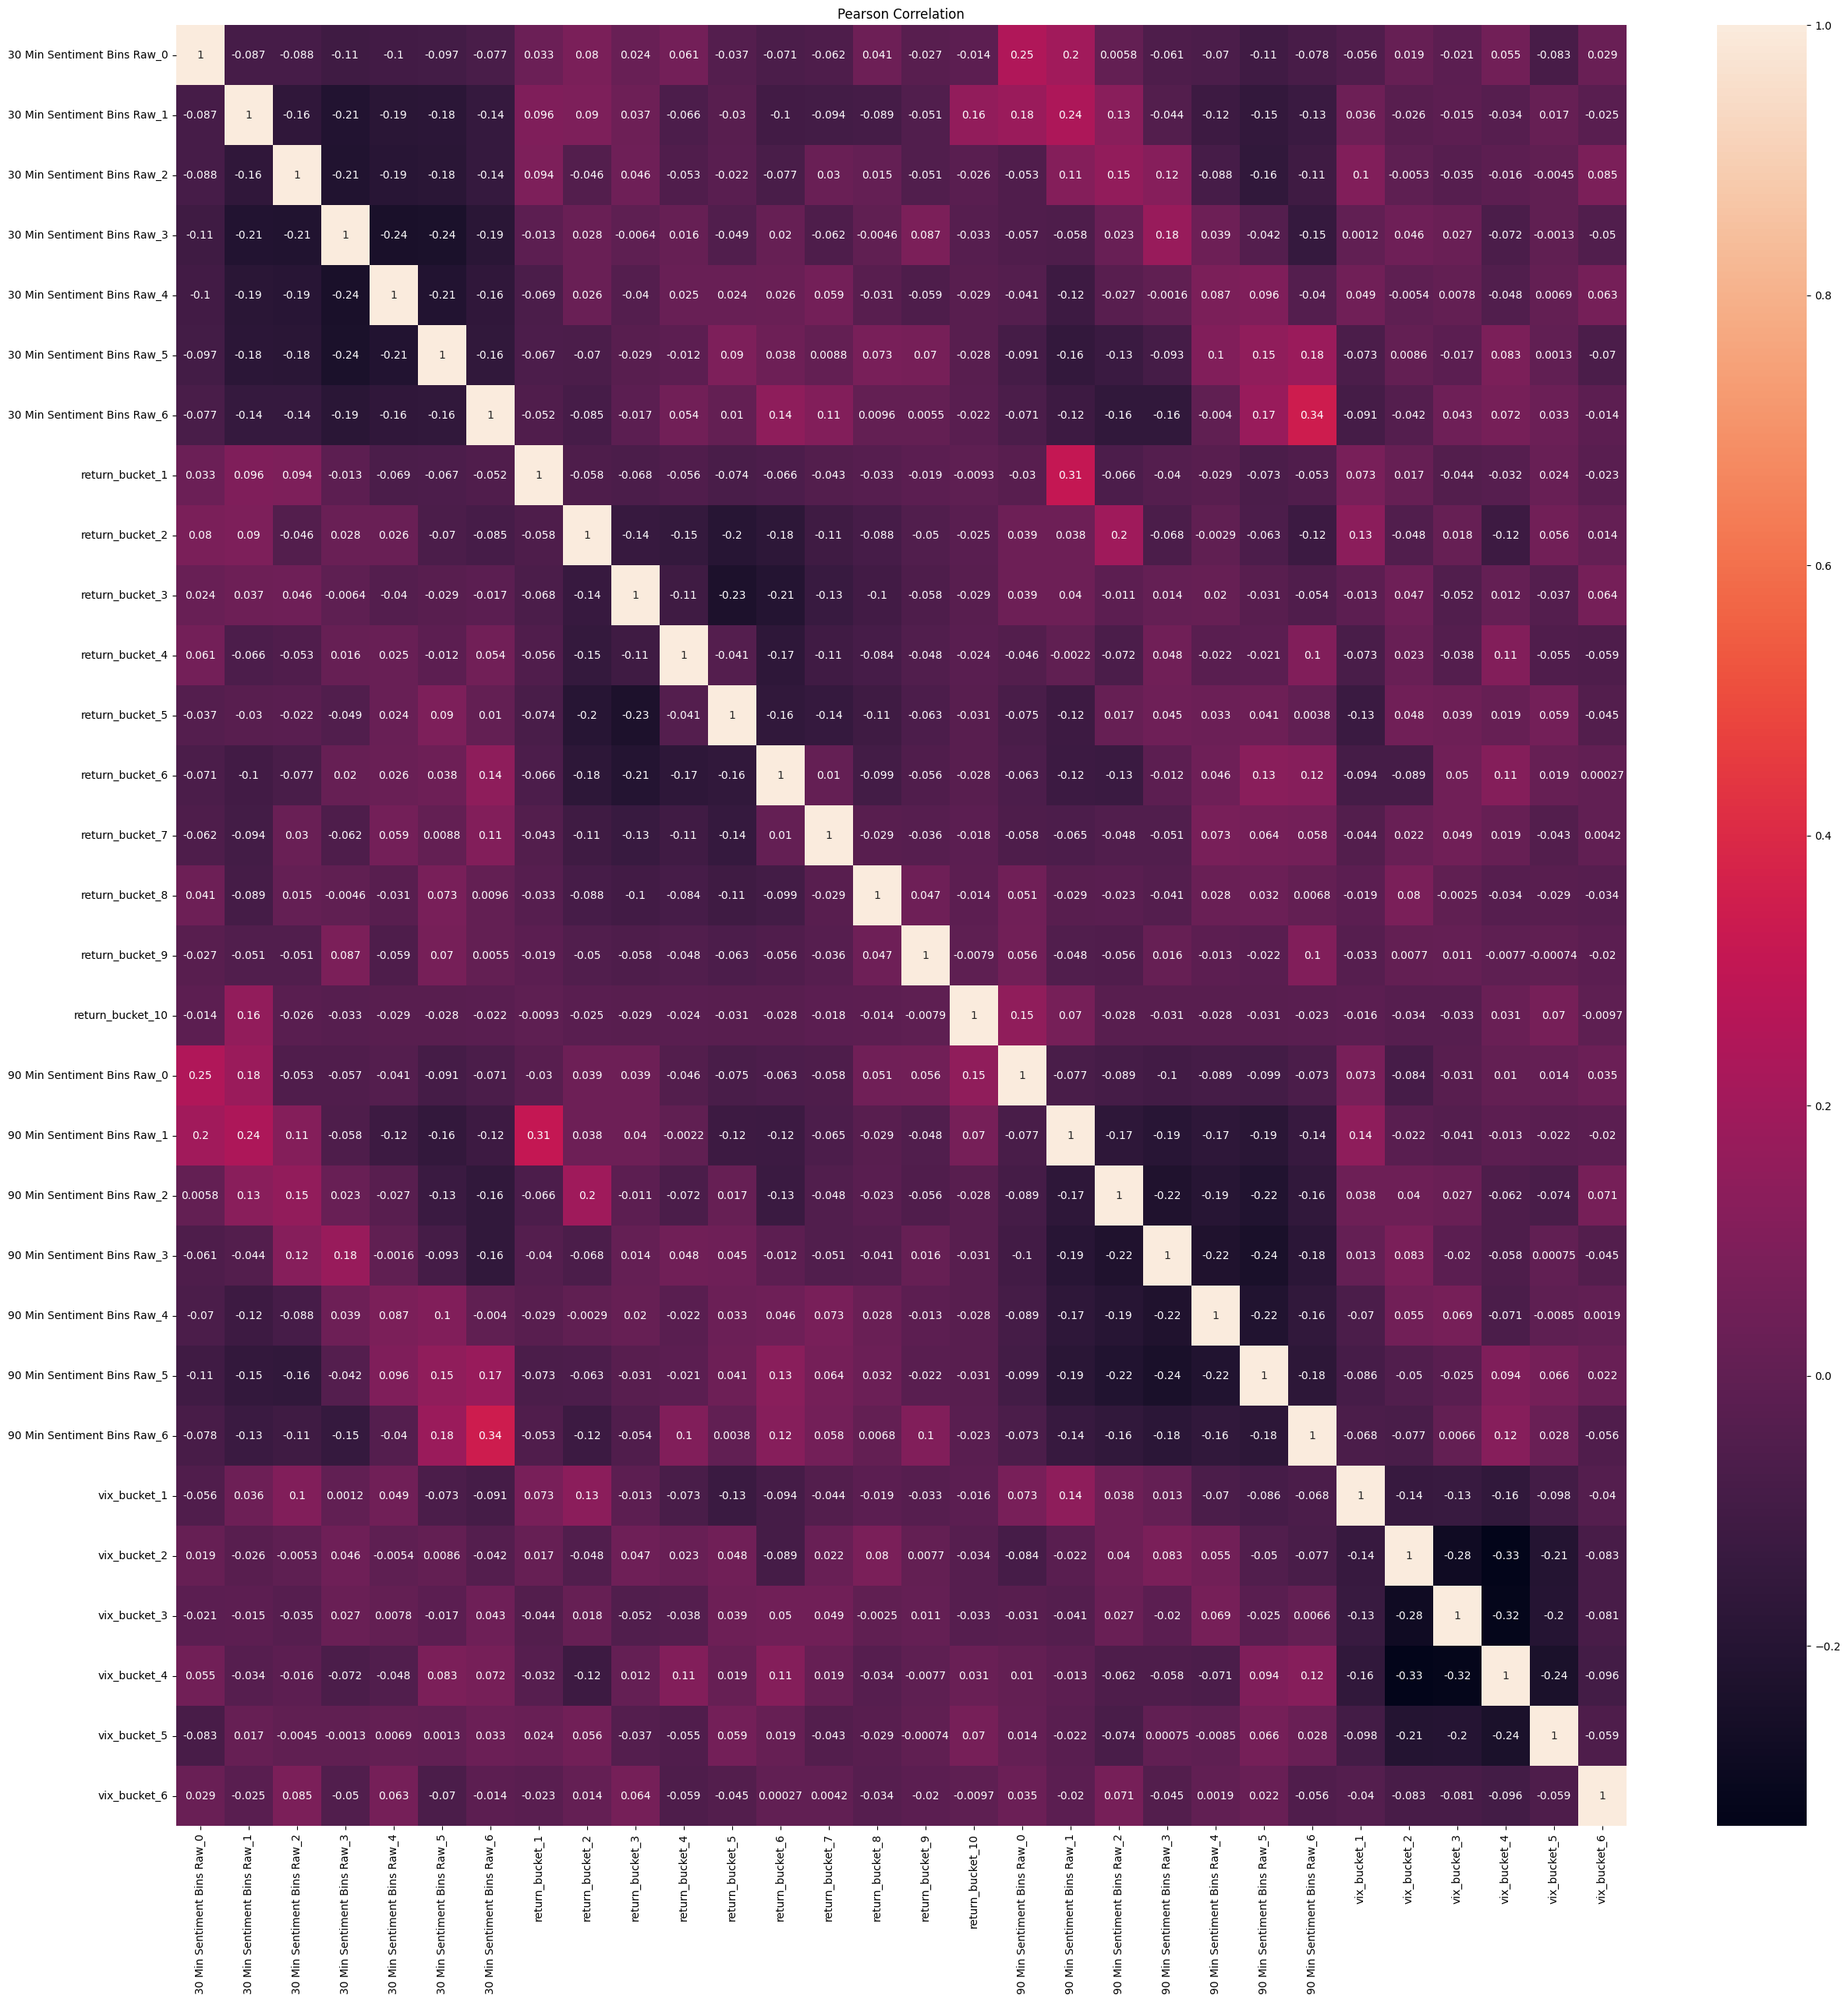

In [1156]:
# Correlation plot of X (numpy array)
plt.figure(figsize=(30, 30))

corrs = np.corrcoef(X, rowvar=False)
plt.title('Pearson Correlation')
sns.heatmap(corrs, annot=True, xticklabels=X.columns, yticklabels=X.columns)


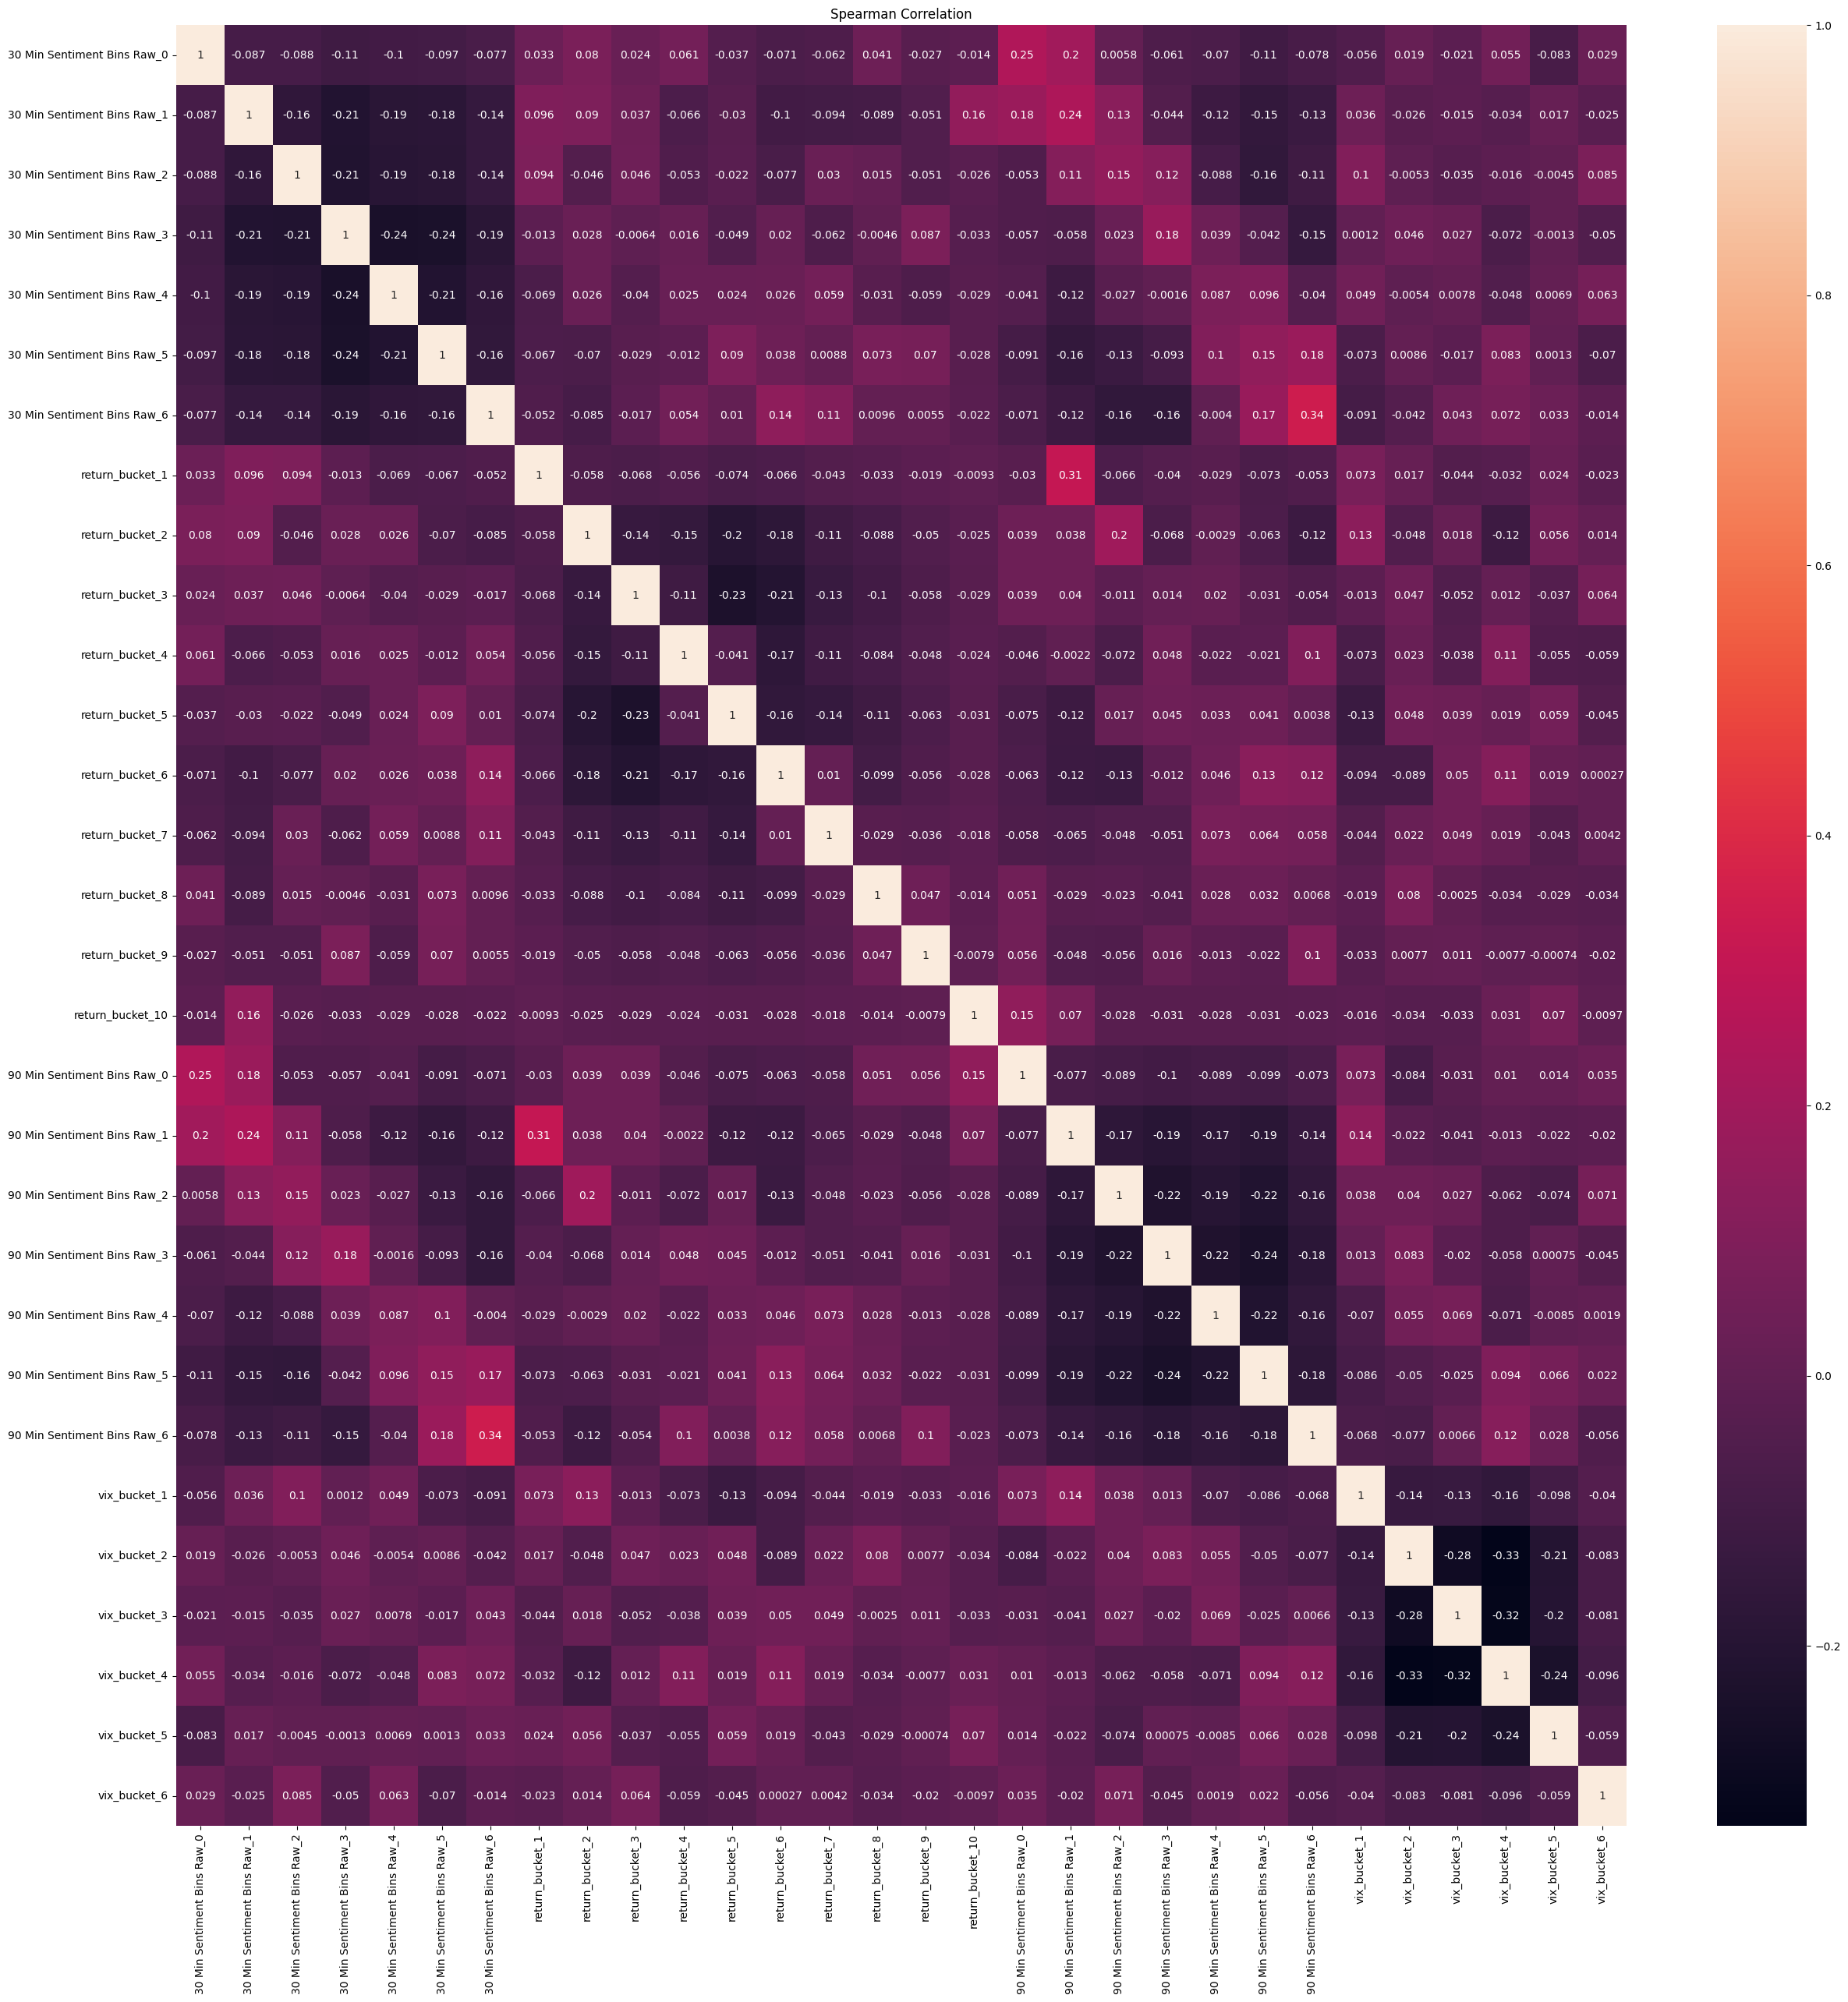

In [1157]:
# Spearman correlation
# corrs = spearmanr(X).correlation
# plt.title('Spearman Correlation')
# sns.heatmap(corrs, annot=True, xticklabels=X.columns, yticklabels=X.columns)
plt.figure(figsize=(30, 30))
corrs = spearmanr(X).statistic
plt.title('Spearman Correlation')
sns.heatmap(corrs, annot=True, xticklabels=X.columns, yticklabels=X.columns)
plt.show()

In [1158]:
y

0     -1
1      1
2      1
3      1
4      1
      ..
507   -1
508    1
509    1
510   -1
511   -1
Name: y, Length: 512, dtype: int64

In [1159]:
X

,30 Min Sentiment Bins Raw_0,30 Min Sentiment Bins Raw_1,30 Min Sentiment Bins Raw_2,30 Min Sentiment Bins Raw_3,30 Min Sentiment Bins Raw_4,30 Min Sentiment Bins Raw_5,30 Min Sentiment Bins Raw_6,return_bucket_1,return_bucket_2,return_bucket_3,...,90 Min Sentiment Bins Raw_3,90 Min Sentiment Bins Raw_4,90 Min Sentiment Bins Raw_5,90 Min Sentiment Bins Raw_6,vix_bucket_1,vix_bucket_2,vix_bucket_3,vix_bucket_4,vix_bucket_5,vix_bucket_6
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
508,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
509,0,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,0
510,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [1160]:
X_feature_names = X.columns

In [1161]:
y = y.values
X = X.values

In [1162]:
y

array([-1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1,
       -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,
        1, -1, -1,  1,  1,  1, -1,  0, -1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,
        1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  0,  1,
       -1, -1, -1,  1,  1,  1,  1,  1, -1,  0,  1, -1,  1, -1,  1, -1,  0,
        0,  1, -1,  1,  1,  1,  1,  1, -1,  1,  0,  1,  1, -1,  1, -1,  1,
       -1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  0,  1,  1,
        1, -1,  1,  1,  1,  1, -1, -1,  1,  0, -1,  1,  1,  1,  0, -1, -1,
        1,  1,  1, -1, -1, -1,  0,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1,
        0,  1,  1,  1, -1,  1,  1,  1,  0,  0, -1,  1, -1, -1,  1, -1,  1,
        1,  1, -1,  1,  0,  0,  1,  1, -1, -1,  1, -1,  1, -1,  0, -1,  0,
       -1,  1, -1,  1,  1,  1,  0,  1,  1,  0, -1,  1, -1,  1,  1,  1,  1,
        0, -1,  1,  1, -1

In [1163]:
X

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [1164]:
def movement_data(X, y, current_index, lookback):
  '''
  Extracts the previous 'lookback' days from current_index to predict the movement of current_index day.

  '''

  # anchored lookback
  if lookback == 0:
    X_train = X[:current_index]
    y_train = y[:current_index]

    X_test = X[current_index]
    y_test = y[current_index]

  else:
    X_train = X[current_index-lookback:current_index]
    y_train = y[current_index-lookback:current_index]

    X_test = X[current_index]
    y_test = y[current_index]

  X_test = X_test.reshape(1, -1)
  y_train = y_train.reshape(-1, 1)
  y_test = y_test.reshape(-1, 1)

  return X_train, y_train, X_test, y_test


In [1165]:
df.head()

,Time,Previous 90 Minute Return (Input),Bucket 1 (-100 - -.80%) Prev 90 minute return,Bucket 2 (-.8% - -.4%) Prev 90 minute return,Bucket 3 (-.40% - -.1%),Bucket 4 (-.1% - .1%),Bucket 5 (.1% - 0.40%) Prev 90 minute return,Bucket 6 (.4% - 0.8%) Prev 90 minute return,Bucket 7 (0.8% - 100%) Prev 90 minute return,Next 240 Minute Return (OutPut),...,Change,%Chg,Volume,vix_bucket_0,vix_bucket_1,vix_bucket_2,vix_bucket_3,vix_bucket_4,vix_bucket_5,vix_bucket_6
0,2020-03-23,-2.05,1,0,0,0,0,0,0,-0.60,...,-0.84,-0.99,0,0,0,0,0,1,0,0
1,2020-03-24,1.31,0,0,0,0,0,0,1,1.30,...,-0.33,-0.46,0,0,0,0,0,1,0,0
2,2020-03-25,0.22,0,0,0,0,1,0,0,3.67,...,1.48,1.92,0,0,0,0,0,0,1,0
3,2020-03-26,2.43,0,0,0,0,0,0,1,1.17,...,-0.12,-0.16,0,0,0,0,0,1,0,0
4,2020-03-27,-0.02,0,0,0,1,0,0,0,1.74,...,-1.12,-1.46,0,0,0,1,0,0,0,0


In [1166]:
range__ = [50, 100, 150, 200, 250, 300, 350, 400]

pred_his = []
pred_his_wins = {}
trees = []

from imblearn.over_sampling import RandomOverSampler

cast = {0 : -1, 1 : 0, 2 : 1}

importances = {}

ros = None
scaler = None
feature_selector = None

for i in range__:
    n=i
    score = 0

    test_df = pd.DataFrame(columns=['Day', 'True Direction', 'Predicted', 'Confidence'])
    test_df['Day'] = df['Time']
    test_df['True Direction'] = df['y']

    preds = []

    for count in tqdm(range(len(X) - n)):
        start_num = n + count
        if start_num < 2:
            continue
        
        try:
            X_train, y_train, X_test, y_test = movement_data(X, y, start_num, n)

            # if the number of classes is 1, skip (use for needed models)
            if len(np.unique(y_train)) == 1:
                continue

            # feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=25, random_state=0))

            # # Feature Selection
            # feature_selector.fit(X_train, y_train)
            # X_train = feature_selector.transform(X_train)
            # X_test = feature_selector.transform(X_test)

            # resample X_train and y_train to balance classes
            ros = RandomOverSampler(random_state=0)
            X_train, y_train = ros.fit_resample(X_train, y_train)

            # Scale data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Feature Selection
            

            # clf = DecisionTreeClassifier(max_depth=4, random_state=0, class_weight='balanced')
            # clf = DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced')
            # clf = RandomForestClassifier(n_estimators=25, max_depth=2, random_state=0, class_weight='balanced')
            clf = RandomForestClassifier(n_estimators=25, max_depth=4, random_state=0, class_weight='balanced')
            # clf = LogisticRegression(random_state=0, class_weight='balanced', max_iter=1000)
            # clf = KNeighborsClassifier(n_neighbors=10, weights='uniform', metric='euclidean')
            # clf = SVC(kernel='linear', probability=True, class_weight='balanced')
            # clf = SVC(kernel='rbf', probability=True, class_weight='balanced')
            # clf = AdaBoostClassifier(n_estimators=25, random_state=0)
            # clf = GaussianNB()

            clf.fit(X_train, y_train)

            pred = clf.predict_proba(X_test)[0]
            pred_dir = cast[np.argmax(pred)]
            pref_conf = max(pred)

            test_df.loc[start_num, 'Predicted'] = pred_dir
            test_df.loc[start_num, 'Confidence'] = pref_conf

        # This is just here for now for models who want multiple classes
        except Exception as e:
            continue

    trees.append(clf)

    pred_his.append(test_df)
    pred_his_wins[i] = test_df

  6%|▋         | 30/462 [00:00<00:08, 51.48it/s]

100%|██████████| 112/112 [00:02<00:00, 51.02it/s]


In [1167]:
unique, counts = np.unique(y, return_counts=True)
vs = dict(zip(unique, counts))

print(f"Number of positive movements:", vs[1] / (vs[1] + vs[0] + vs[-1]))

Number of positive movements: 0.537109375


In [1168]:
# In order to make results comparable, we need to only use dates that all models have predictions for
first_date = pred_his[-1]['Predicted'].first_valid_index()

In [1169]:
pred_his[0]

,Day,True Direction,Predicted,Confidence
0,2020-03-23,-1,NaN,NaN
1,2020-03-24,1,NaN,NaN
2,2020-03-25,1,NaN,NaN
3,2020-03-26,1,NaN,NaN
4,2020-03-27,1,NaN,NaN
...,...,...,...,...
507,2022-03-25,-1,1,0.351228
508,2022-03-28,1,1,0.386938
509,2022-03-29,1,1,0.533419
510,2022-03-30,-1,1,0.514255


In [1170]:
pred_his[-1]

,Day,True Direction,Predicted,Confidence
0,2020-03-23,-1,NaN,NaN
1,2020-03-24,1,NaN,NaN
2,2020-03-25,1,NaN,NaN
3,2020-03-26,1,NaN,NaN
4,2020-03-27,1,NaN,NaN
...,...,...,...,...
507,2022-03-25,-1,-1,0.341187
508,2022-03-28,1,1,0.531162
509,2022-03-29,1,0,0.354086
510,2022-03-30,-1,0,0.398175


In [1171]:
# plt.figure(figsize=(40, 40))
# plot_tree(trees[5], filled=True, feature_names=['Previous 90 Minute Return (Input)',
#        'Bucket 1 (-100 - -.80%) Prev 90 minute return',
#        'Bucket 2 (-.8% - -.4%) Prev 90 minute return ',
#        'Bucket 3 (-.40% - -.1%)', 'Bucket 4 (-.1% - .1%)',
#        'Bucket 5 (.1% - 0.40%) Prev 90 minute return',
#        'Bucket 6 (.4% - 0.8%) Prev 90 minute return',
#        'Bucket 7 (0.8% - 100%) Prev 90 minute return', 'Day_Of_Year', 'Day_of_Month',
#        'Day_Of_Week_0', 'Day_Of_Week_1', 'Day_Of_Week_2', 'Day_Of_Week_3',
#        'Day_Of_Week_4', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
#        'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
#        'Month_12'], class_names=["-1", "0", "1"], fontsize=14)
# plt.show()

 1    58
 0    28
-1    26
Name: Predicted, dtype: int64
 1    56
-1    41
 0    15
Name: True Direction, dtype: int64


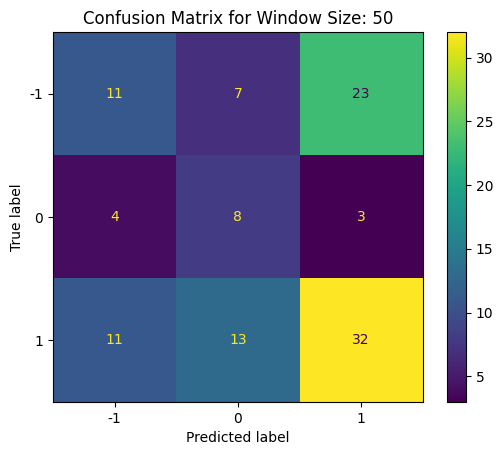

 0    46
 1    40
-1    26
Name: Predicted, dtype: int64
 1    56
-1    41
 0    15
Name: True Direction, dtype: int64


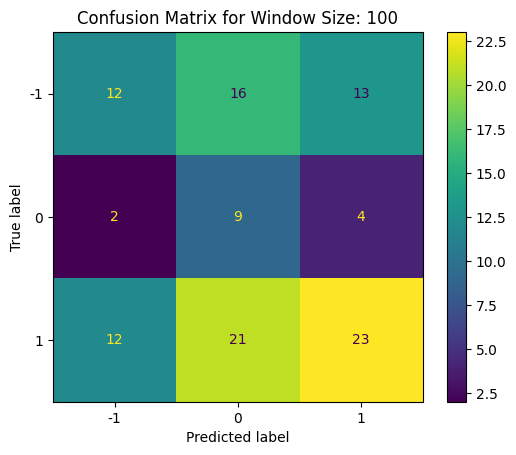

 1    56
 0    28
-1    28
Name: Predicted, dtype: int64
 1    56
-1    41
 0    15
Name: True Direction, dtype: int64


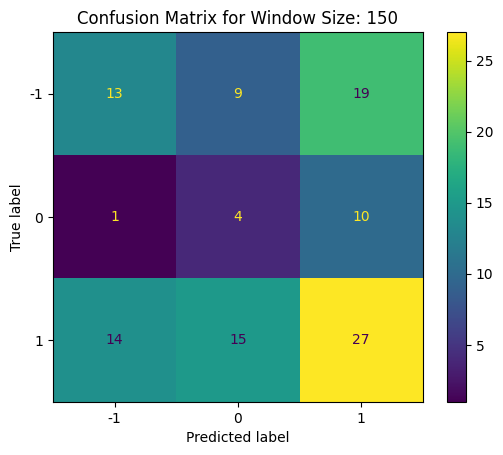

 1    48
 0    33
-1    31
Name: Predicted, dtype: int64
 1    56
-1    41
 0    15
Name: True Direction, dtype: int64


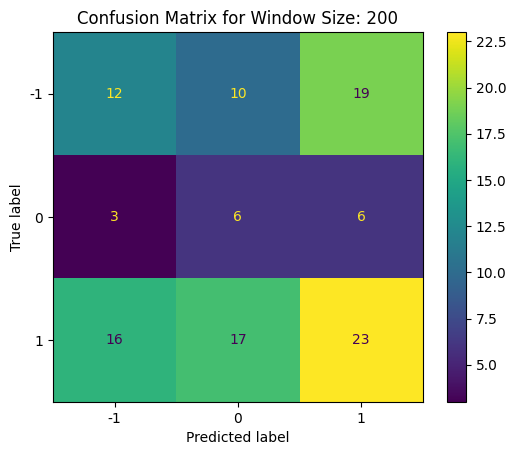

 1    50
 0    33
-1    29
Name: Predicted, dtype: int64
 1    56
-1    41
 0    15
Name: True Direction, dtype: int64


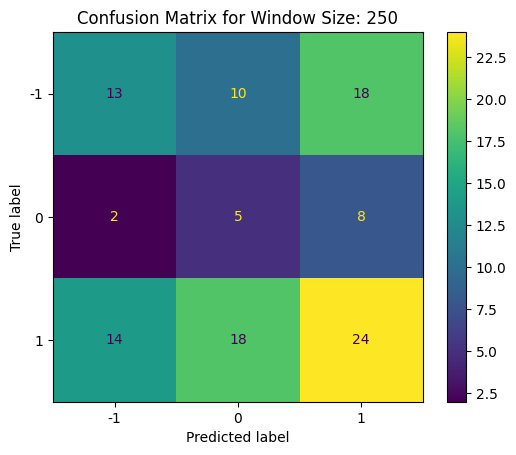

 1    46
 0    44
-1    22
Name: Predicted, dtype: int64
 1    56
-1    41
 0    15
Name: True Direction, dtype: int64


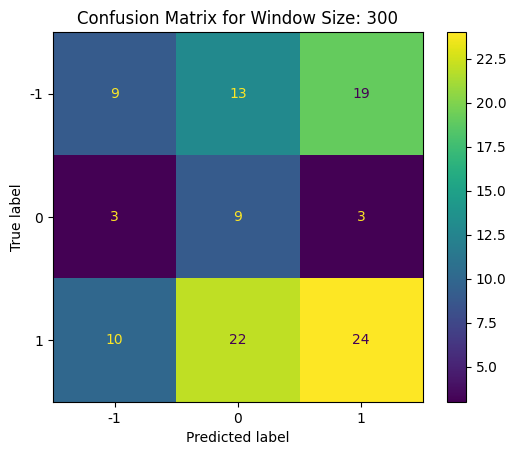

 1    43
 0    38
-1    31
Name: Predicted, dtype: int64
 1    56
-1    41
 0    15
Name: True Direction, dtype: int64


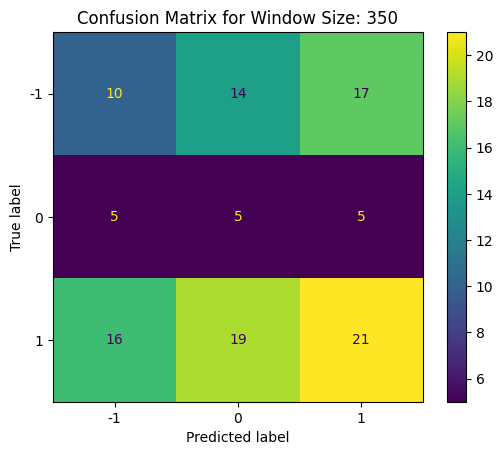

 1    48
 0    36
-1    28
Name: Predicted, dtype: int64
 1    56
-1    41
 0    15
Name: True Direction, dtype: int64


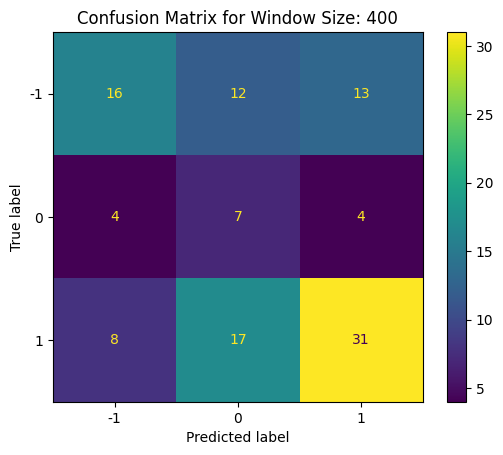

In [1172]:
# Confusion matrix
for i in range(len(pred_his)):
    true = pred_his[i].loc[first_date:, 'True Direction'].astype(int)
    pred = pred_his[i].loc[first_date:, 'Predicted'].astype(int)

    # Show sum of each class of predictions
    print(pred.value_counts())

    # Shot the sum of each class of true values
    print(true.value_counts())

    cm = confusion_matrix(true, pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
    disp.plot()

    plt.title('Confusion Matrix for Window Size: ' + str(range__[i]))

    plt.show()

In [1173]:
pred_his[1][pred_his[1]['Predicted'] == 1].count()

Day               181
True Direction    181
Predicted         181
Confidence        181
dtype: int64

In [1174]:
def calc_stats(pred, true, conf):
    '''
    Calculates the accuracy, long precision, short precision, long n, short n, true long, true short, and long-short ratio
    '''

    ret = {}

    cm = confusion_matrix(true, pred, labels=[-1, 0, 1])

    # ret['Accuracy'] = ((cm[0][0] + cm[2][2]) / (cm[0][0] + cm[2][2] + cm[0][2] + cm[2][0]) * 100).round(3)
    ret['Long Precision'] = ((cm[2][2]) / (cm[2][2] + cm[1][2] + cm[0][2]) * 100).round(3)
    ret['Short Precision'] = ((cm[0][0]) / (cm[0][0] + cm[1][0] + cm[2][0]) * 100).round(3)
    ret['Long N'] = pred[pred==1].count()
    ret['Short N'] = pred[pred==-1].count()
    ret['True Long'] = true[true==1].count()
    ret['True Short'] = true[true==-1].count()
    ret['Long-Short Ratio'] = (ret['Long N'] / ret['Short N']).round(3)
    ret['Trade Percent'] = ((ret['Long N'] + ret['Short N']) / len(pred) * 100).round(3)

    # long precision and n for 0.1 <= confidence
    oh_ten = pred[conf >= 0.45]
    oh_ten_true = true[conf >= 0.45]
    cm_two = confusion_matrix(oh_ten_true, oh_ten, labels=[-1, 0, 1])
    ret['Long Precision 0.45'] = ((cm_two[2][2]) / (cm_two[2][2] + cm_two[1][2] + cm_two[0][2]) * 100).round(3)
    ret['Long N 0.45'] = oh_ten[oh_ten==1].count()
    # ret['Short Precision 0.05'] = ((cm_two[0][0]) / (cm_two[0][0] + cm_two[2][0]) * 100).round(3)
    # ret['Short N 0.1'] = oh_ten[oh_ten==-1].count()

    # long precision and n for 0.2 <= confidence
    oh_ten = pred[conf >= 0.55]
    oh_ten_true = true[conf >= 0.55]
    cm_two = confusion_matrix(oh_ten_true, oh_ten, labels=[-1, 0, 1])
    ret['Long Precision 0.55'] = ((cm_two[2][2]) / (cm_two[2][2] + cm_two[1][2] + cm_two[0][2]) * 100).round(3)
    print(ret['Long Precision 0.55'])
    ret['Long N 0.55'] = oh_ten[oh_ten==1].count()
    
    ret['F1'] = f1_score(true, pred, average='micro').round(3)

    # put the long precisions and ns close to each other
    ret = {k: ret[k] for k in ['Long Precision', 'Long Precision 0.45', 'Long Precision 0.55', 'Long N', 'Long N 0.45', 'Long N 0.55', 'Short Precision', 'Short N', 'True Long', 'True Short', 'Long-Short Ratio', 'Trade Percent', 'F1']}
    
    # Replace nans with 0
    ret = {k: 0 if math.isnan(ret[k]) else ret[k] for k in ret}

    return ret

In [1175]:


results_df = pd.DataFrame(columns=['Window', 'True Long', 'True Short', 'Long N', 'Short N', 'Accuracy', 'Long Precision', 'Short Precision', 'Long-Short Ratio', 'Trade Percent'])

for i in range(len(pred_his)):

    # Get the accuracy of each model in pred_his
    first_date = pred_his[i]['Predicted'].first_valid_index()

    # first_date = pred_his[i]['Predicted'].first_valid_index()
    true = pred_his[i].loc[first_date:, 'True Direction'].astype(int)
    pred = pred_his[i].loc[first_date:, 'Predicted'].astype(int)
    conf = pred_his[i].loc[first_date:, 'Confidence'].astype(float)

    # Print the overall accuracy and F1 score
    results_df.loc[i, 'Window'] = range__[i]
    
    ret = calc_stats(pred, true, conf)

    for k in ret.keys():
        results_df.loc[i, k] = ret[k]

# results_df.dropna(inplace=True, axis=1)

results_df


55.714
50.0
50.0
50.0
0.0
0.0
33.333
0.0


,Window,True Long,True Short,Long N,Short N,Accuracy,Long Precision,Short Precision,Long-Short Ratio,Trade Percent,Long Precision 0.45,Long Precision 0.55,Long N 0.45,Long N 0.55,F1
0,50,245,157,231,156,NaN,56.277,34.615,1.481,83.766,54.878,55.714,164.0,70.0,0.435
1,100,216,138,181,135,NaN,56.906,37.037,1.341,76.699,54.000,50.000,100.0,24.0,0.425
2,150,188,121,170,116,NaN,52.941,36.207,1.466,79.006,45.455,50.000,44.0,8.0,0.398
3,200,164,102,140,97,NaN,52.143,34.021,1.443,75.962,44.118,50.000,34.0,4.0,0.391
4,250,137,86,118,72,NaN,51.695,37.5,1.639,72.519,60.000,0.000,25.0,1.0,0.389
5,300,106,70,87,54,NaN,49.425,29.63,1.611,66.509,47.059,0.000,17.0,2.0,0.358
6,350,78,55,67,46,NaN,44.776,21.739,1.457,69.753,50.000,33.333,12.0,3.0,0.302
7,400,56,41,48,28,NaN,64.583,57.143,1.714,67.857,50.000,0.000,12.0,1.0,0.482


In [1176]:
# Print accuracy of going long every day
long_every_day = (df[df['y'] == 1].shape[0]) / df.shape[0]
print("Accuracy of going long every day:", long_every_day * 100)

Accuracy of going long every day: 53.7109375


In [1177]:
# Minimum number of trades (For confidence)
min_n = 200

In [1178]:
# # For each window, plot the prediction confidence versus accuracy of predictions with that confidence or higher
# for i in range(len(pred_his)):
#     first_date = pred_his[i]['Predicted'].first_valid_index()
#     true = pred_his[i].loc[first_date:, 'True Direction'].astype(int)
#     pred = pred_his[i].loc[first_date:, 'Predicted'].astype(int)
#     conf = pred_his[i].loc[first_date:, 'Confidence'].astype(float)


#     conf_vals = conf.sort_values().unique()

#     accs = []
#     confs = []

#     for j in range(len(conf_vals)):
#         trues = true[conf >= conf_vals[j]]
#         preds = pred[conf >= conf_vals[j]]

#         # if we are at only 50 trades, break
#         if len(trues) < min_n:
#             break

#         cm = confusion_matrix(trues, preds, labels=[-1, 0, 1])
#         accs.append(((cm[0][0] + cm[2][2]) / (cm[0][0] + cm[2][2] + cm[0][2] + cm[2][0]) * 100))
#         confs.append(conf_vals[j])

#     counts = []

#     for j in range(len(confs)):
#         counts.append(pred[conf >= conf_vals[j]].count())
        
#     fig = plt.figure(figsize=(10, 10))
#     gs = GridSpec(4, 1, figure=fig)
    
#     ax_line = fig.add_subplot(gs[0:3, :])
#     ax_bar = fig.add_subplot(gs[3, :])


#     # draw a horizontal line at the accuracy of going long every day
#     # ax_line.axhline(y=long_every_day, color='r', linestyle='--', alpha=0.5)

#     ax_line.plot(confs, accs)
#     ax_line.set_ylabel('Accuracy')


#     ax_line.title.set_text("Confidence vs Accuracy and Count for Window Size " + str(range__[i]))

#     ax_bar.plot(confs, counts)
#     ax_bar.set_ylabel('Count')
#     ax_bar.set_xlabel('Confidence')
#     ax_bar.fill_between(confs, counts, 0, alpha=0.5)

#     # plot the figure
#     plt.show()


In [1179]:
# # For each window, plot the prediction confidence versus accuracy of predictions with that confidence or higher
# for i in range(len(pred_his)):
#     first_date = pred_his[i]['Predicted'].first_valid_index()
#     true = pred_his[i].loc[first_date:, 'True Direction'].astype(int)
#     pred = pred_his[i].loc[first_date:, 'Predicted'].astype(int)
#     conf = pred_his[i].loc[first_date:, 'Confidence'].astype(float)


#     conf_vals = conf.sort_values().unique()

#     accs = []
#     confs = []
#     counts = []

#     for j in range(len(conf_vals)):
#         trues = true[conf >= conf_vals[j]]
#         preds = pred[conf >= conf_vals[j]]

#         # get the count of non-zero predictions
#         non_zero_count = preds[preds != 0].count()

#         # if we are at only 50 trades, break
#         if non_zero_count < min_n:
#             break

#         cm = confusion_matrix(trues, preds, labels=[-1, 0, 1])
#         accs.append((cm[2][2]) / (cm[2][2] + cm[1][2] + cm[0][2]) * 100)
#         confs.append(conf_vals[j])
#         counts.append(non_zero_count)

#     fig = plt.figure(figsize=(10, 10))
#     gs = GridSpec(4, 1, figure=fig)
    
#     ax_line = fig.add_subplot(gs[0:3, :])
#     ax_bar = fig.add_subplot(gs[3, :])


#     # draw a horizontal line at the accuracy of going long every day
#     # ax_line.axhline(y=long_every_day, color='r', linestyle='--', alpha=0.5)

#     ax_line.plot(confs, accs)
#     ax_line.set_ylabel('Long Precision')


#     ax_line.title.set_text("Confidence vs Long Precision and Count for Window Size " + str(range__[i]))

#     ax_bar.plot(confs, counts)
#     ax_bar.set_ylabel('Count')
#     ax_bar.set_xlabel('Confidence')
#     ax_bar.fill_between(confs, counts, 0, alpha=0.5)

#     # plot the figure
#     plt.show()


In [1180]:
# # For each window, plot the prediction confidence versus accuracy of predictions with that confidence or higher
# for i in range(len(pred_his)):
#     first_date = pred_his[i]['Predicted'].first_valid_index()
#     true = pred_his[i].loc[first_date:, 'True Direction'].astype(int)
#     pred = pred_his[i].loc[first_date:, 'Predicted'].astype(int)
#     conf = pred_his[i].loc[first_date:, 'Confidence'].astype(float)


#     conf_vals = conf.sort_values().unique()

#     accs = []
#     confs = []
#     counts = []

#     for j in range(len(conf_vals)):
#         trues = true[conf >= conf_vals[j]]
#         preds = pred[conf >= conf_vals[j]]

#         # get the count of non-zero predictions
#         non_zero_count = preds[preds != 0].count()

#         # if we are at only 50 trades, break
#         if non_zero_count < min_n:
#             break

#         cm = confusion_matrix(trues, preds, labels=[-1, 0, 1])
#         accs.append(((cm[0][0]) / (cm[0][0] + cm[1][0] + cm[2][0]) * 100))
#         confs.append(conf_vals[j])
#         counts.append(non_zero_count)
        
#     fig = plt.figure(figsize=(10, 10))
#     gs = GridSpec(4, 1, figure=fig)
    
#     ax_line = fig.add_subplot(gs[0:3, :])
#     ax_bar = fig.add_subplot(gs[3, :])


#     # draw a horizontal line at the accuracy of going long every day
#     # ax_line.axhline(y=long_every_day, color='r', linestyle='--', alpha=0.5)

#     ax_line.plot(confs, accs)
#     ax_line.set_ylabel('Short Precision')


#     ax_line.title.set_text("Confidence vs Short Precision and Count for Window Size " + str(range__[i]))

#     ax_bar.plot(confs, counts)
#     ax_bar.set_ylabel('Count')
#     ax_bar.set_xlabel('Confidence')
#     ax_bar.fill_between(confs, counts, 0, alpha=0.5)

#     # plot the figure
#     plt.show()


In [1181]:
# # Plot the accuracies of each window
# plt.figure(figsize=(20, 10))
# x_windows = np.linspace(0, len(pred_his)-1, len(pred_his))
# plt.plot(x_windows, results_df['Accuracy'])
# plt.title("Accuracy vs Window Size")

Text(0.5, 1.0, 'Accuracy vs Window Size')

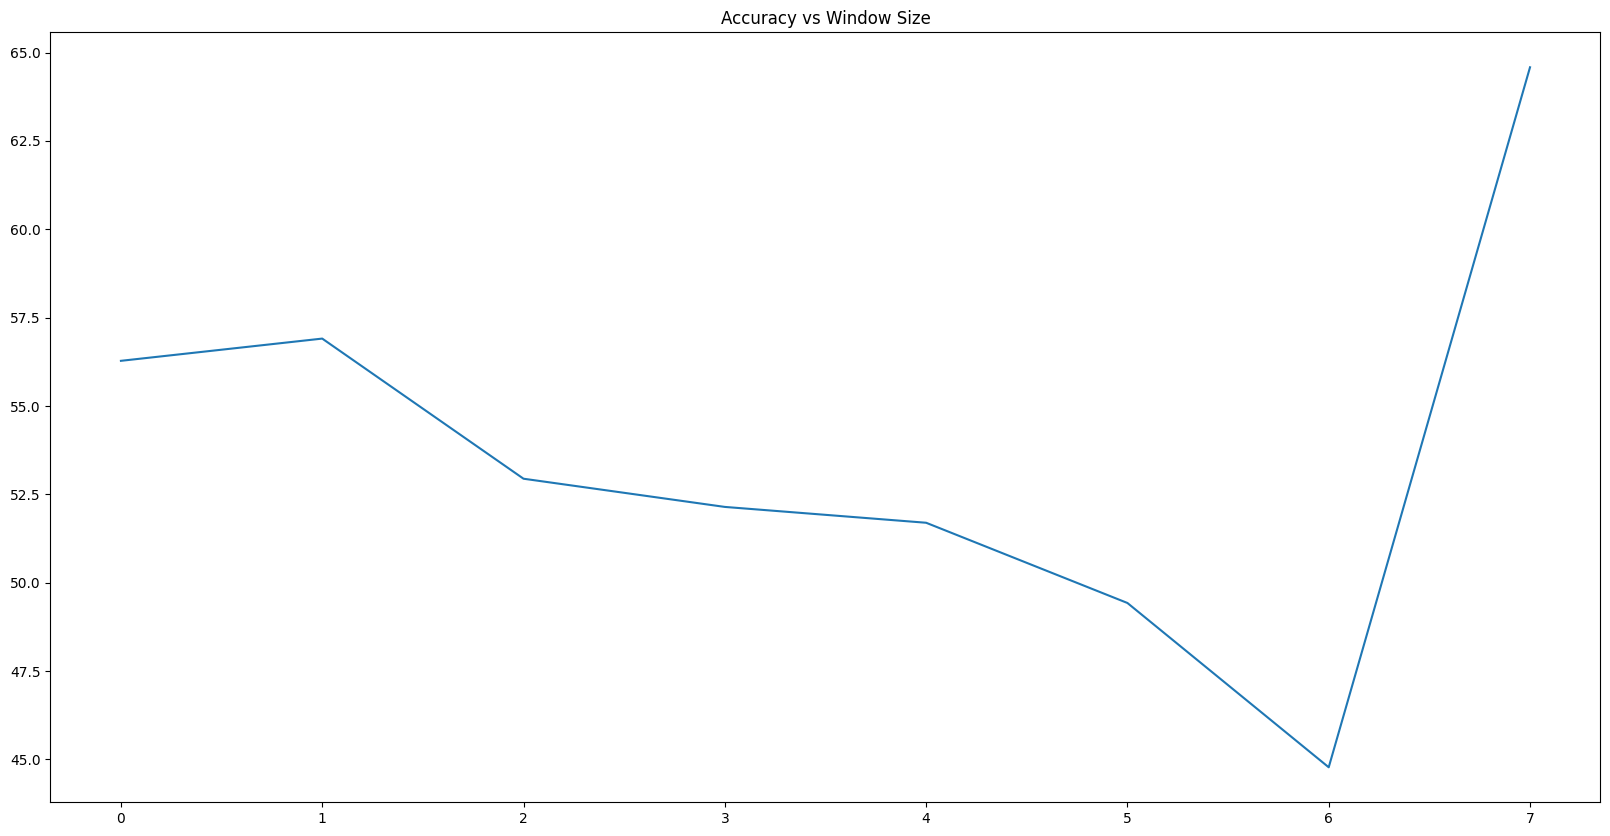

In [1182]:
# Plot the accuracies of each window
plt.figure(figsize=(20, 10))
x_windows = np.linspace(0, len(pred_his)-1, len(pred_his))
plt.plot(x_windows, results_df['Long Precision'])
plt.title("Accuracy vs Window Size")

In [1183]:
year_dfs = {}

In [1184]:
# for year in range(2016, 2024):
#     # Get the accuracy of each model in pred_his

#     xresults_df = pd.DataFrame(columns=['Window', 'True Long', 'True Short', 'Long N', 'Short N', 'Accuracy', 'Long Precision', 'Short Precision', 'Long-Short Ratio', 'Trade Percent'])

#     year_indeces = df[df['Time'].dt.year == year].index

#     year_df = df.loc[year_indeces[0]:year_indeces[-1]]

#     for i in range(len(pred_his)):

#         pred_df = pred_his[i].loc[year_indeces[0]:year_indeces[-1]]

#         first_date = pred_df['Predicted'].first_valid_index()

#         if first_date == None:
#             continue

#         true = pred_df.loc[first_date:, 'True Direction'].astype(int)
#         pred = pred_df.loc[first_date:, 'Predicted'].astype(int)
#         conf = pred_df.loc[first_date:, 'Confidence'].astype(float)

#         # Print the overall accuracy and F1 score
#         xresults_df.loc[i, 'Window'] = range__[i]
#         ret = calc_stats(pred, true, conf)

#         for k in ret.keys():
#             xresults_df.loc[i, k] = ret[k]

#         # fill nans
#         xresults_df.fillna(0, inplace=True)

#     year_dfs[year] = xresults_df


In [1185]:
# # plot long precision for each year per window size
# for year in year_dfs.keys():
#     plt.figure(figsize=(20, 10))
#     x_windows = np.linspace(0, len(year_dfs[year])-1, len(year_dfs[year]))
#     plt.plot(x_windows, year_dfs[year]['Long Precision'])
#     plt.xticks(x_windows, year_dfs[year]['Window'])
#     plt.title("Long Precision vs Window Size for " + str(year))

In [1186]:
# print the sampler name, scaler name, class name, parameters used in the models, model hyperparameters
# print(f'Sampler: {ros.__class__.__name__}')
# print(f'Scaler: {scaler.__class__.__name__}')
# print(f'Class: {clf.__class__.__name__}')
# print(f'Parameters: {list(X_feature_names)}')
# print(f'Hyperparameters: {clf.get_params()}')

feature_selector_name = str(feature_selector.__class__.__name__)
sampler = str(ros.__class__.__name__)
scaler_name = str(scaler.__class__.__name__)
clf_name = str(clf.__class__.__name__)
parameters = str(list(X_feature_names))
hyperparameters = str(clf.get_params())

results_Overall = results_df['Long Precision'].to_numpy().reshape(-1, 1)


In [1187]:
# results_2022 = year_dfs[2022]['Long Precision'].to_numpy().reshape(-1, 1)

In [1188]:
# results_2023 = year_dfs[2023]['Long Precision'].to_numpy().reshape(-1, 1)

In [1189]:
import time

In [1190]:
# save the pred_his_wins each to a csv

curr_time = time.time()

for w, df in pred_his_wins.items():
    df.to_csv(f'{sampler}_{scaler_name}_{clf_name}_{w}_{curr_time}.csv')

In [1191]:
csv_ids = {}

service = build("drive", "v3", credentials=creds)

# upload the csvs to the google drive
for w, df in pred_his_wins.items():
    try:
        file_name = f'{sampler}_{scaler_name}_{clf_name}_{w}_{curr_time}.csv'
        file_metadata = {
            'name': file_name,
            'parents': ['1lMRrV0uY_5TwES8zMUIawJPQ2s_Fp4Ah']
        }
        media = MediaFileUpload(file_name, mimetype='text/csv')

        file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

        csv_ids[w] = file.get('id')
    except Exception as e:
        print(e)

In [1192]:
csv_ids

{50: '1OJHRazfWvmwZqEREZl2WuzwBIJGOm_SF',
 100: '1rJUyLHwokdmfxoK3BXVQ9CYypTf5Kk34',
 150: '1toOppW-kt6yvPrAzQgiCdqtFk_i_cflO',
 200: '1hm5nafkmBTXvPSTmxm1NTbKtOV96c1Z_',
 250: '1cv-l1LXucx_0eLi3PpVQuODIX99mUAkW',
 300: '1KkMfwrLDlSjuDqt3rjTAYc5GjG-x1bbP',
 350: '1gHPDkAar84ROVEREeltUs6NzD51pJeGU',
 400: '1v504t16pUXrSteKijya2e_Psj4-ShSVy'}

In [1193]:
results_Overall

array([[56.277],
       [56.906],
       [52.941],
       [52.143],
       [51.695],
       [49.425],
       [44.776],
       [64.583]], dtype=object)

In [1194]:
# convert numbers in results_* dataframes to hyperlink strings
results_overall_list = []
results_2022_list = []
results_2023_list = []

for i in range(len(results_Overall)):
    results_overall_list.append([f'=HYPERLINK("https://drive.google.com/file/d/{csv_ids[range__[i]]}/view?usp=sharing", {results_Overall[i][0]})'
    ])

# for i in range(len(results_2022)):
#     results_2022_list.append([f'=HYPERLINK("https://drive.google.com/file/d/{csv_ids[range__[i]]}/view?usp=sharing", {results_2022[i][0]})'])

# for i in range(len(results_2023)):
#     results_2023_list.append([f'=HYPERLINK("https://drive.google.com/file/d/{csv_ids[range__[i]]}/view?usp=sharing", {results_2023[i][0]})'])

# for i in range(len(results_Overall)):
#     print(f'=HYPERLINK("https://drive.google.com/file/d/{csv_ids[range__[i]]}/ciew?usp=sharing", "{results_Overall[i]}")')
#     results_Overall[i] = f'=HYPERLINK("https://drive.google.com/file/d/{csv_ids[range__[i]]}/ciew?usp=sharing", "{results_Overall[i]}")'
#     print(results_Overall[i])

# for i in range(len(results_2022)):
#     results_2022[i] = f'=HYPERLINK("https://drive.google.com/file/d/{csv_ids[range__[i]]}/ciew?usp=sharing", "{results_2022[i]}")'

# for i in range(len(results_2023)):
#     results_2023[i] = f'=HYPERLINK("https://drive.google.com/file/d/{csv_ids[range__[i]]}/ciew?usp=sharing", "{results_2023[i]}")'

In [1195]:
results_overall_list

[['=HYPERLINK("https://drive.google.com/file/d/1OJHRazfWvmwZqEREZl2WuzwBIJGOm_SF/view?usp=sharing", 56.277)'],
 ['=HYPERLINK("https://drive.google.com/file/d/1rJUyLHwokdmfxoK3BXVQ9CYypTf5Kk34/view?usp=sharing", 56.906)'],
 ['=HYPERLINK("https://drive.google.com/file/d/1toOppW-kt6yvPrAzQgiCdqtFk_i_cflO/view?usp=sharing", 52.941)'],
 ['=HYPERLINK("https://drive.google.com/file/d/1hm5nafkmBTXvPSTmxm1NTbKtOV96c1Z_/view?usp=sharing", 52.143)'],
 ['=HYPERLINK("https://drive.google.com/file/d/1cv-l1LXucx_0eLi3PpVQuODIX99mUAkW/view?usp=sharing", 51.695)'],
 ['=HYPERLINK("https://drive.google.com/file/d/1KkMfwrLDlSjuDqt3rjTAYc5GjG-x1bbP/view?usp=sharing", 49.425)'],
 ['=HYPERLINK("https://drive.google.com/file/d/1gHPDkAar84ROVEREeltUs6NzD51pJeGU/view?usp=sharing", 44.776)'],
 ['=HYPERLINK("https://drive.google.com/file/d/1v504t16pUXrSteKijya2e_Psj4-ShSVy/view?usp=sharing", 64.583)']]

In [1196]:
results_df

,Window,True Long,True Short,Long N,Short N,Accuracy,Long Precision,Short Precision,Long-Short Ratio,Trade Percent,Long Precision 0.45,Long Precision 0.55,Long N 0.45,Long N 0.55,F1
0,50,245,157,231,156,NaN,56.277,34.615,1.481,83.766,54.878,55.714,164.0,70.0,0.435
1,100,216,138,181,135,NaN,56.906,37.037,1.341,76.699,54.000,50.000,100.0,24.0,0.425
2,150,188,121,170,116,NaN,52.941,36.207,1.466,79.006,45.455,50.000,44.0,8.0,0.398
3,200,164,102,140,97,NaN,52.143,34.021,1.443,75.962,44.118,50.000,34.0,4.0,0.391
4,250,137,86,118,72,NaN,51.695,37.5,1.639,72.519,60.000,0.000,25.0,1.0,0.389
5,300,106,70,87,54,NaN,49.425,29.63,1.611,66.509,47.059,0.000,17.0,2.0,0.358
6,350,78,55,67,46,NaN,44.776,21.739,1.457,69.753,50.000,33.333,12.0,3.0,0.302
7,400,56,41,48,28,NaN,64.583,57.143,1.714,67.857,50.000,0.000,12.0,1.0,0.482


In [1197]:
# Delete files from local
import os

for w, df in pred_his_wins.items():
    try:
        file_name = f'{sampler}_{scaler_name}_{clf_name}_{w}_{curr_time}.csv'
        os.remove(file_name)
    except Exception as e:
        print(e)

In [1198]:
def convert_gdrive_str(df, res_list):
    init_body = [
        [feature_selector_name],
        [sampler],
        [scaler_name],
        [clf_name],
        [hyperparameters],
        [parameters],
        [""],
    ]

    init_body = init_body + res_list
    init_body += [[""]]
    init_body = init_body + df['Short Precision'].to_numpy().reshape(-1, 1).tolist()
    init_body += [[""]]
    init_body = init_body + df['Long-Short Ratio'].to_numpy().reshape(-1, 1).tolist()
    init_body += [[""]]
    init_body = init_body + df['Trade Percent'].to_numpy().reshape(-1, 1).tolist()
    init_body += [[""]]
    init_body = init_body + df['Long Precision 0.45'].to_numpy().reshape(-1, 1).tolist()
    init_body += [[""]]
    init_body = init_body + df['Long Precision 0.55'].to_numpy().reshape(-1, 1).tolist()
    init_body += [[""]]
    # init_body = init_body + df['Long N'].astype(str).to_numpy().reshape(-1, 1).tolist()
    # init_body += [[""]]
    # init_body = init_body + df['Short N'].astype(str).to_numpy().reshape(-1, 1).tolist()
    # init_body += [[""]]
    
    # combine Long N and True Long in format Long N "(True Long)"
    long_n = df['Long N'].to_numpy()
    true_long = df['True Long'].to_numpy()
    long_n = [f"{long_n[i]} ({true_long[i]})" for i in range(len(long_n))]
    init_body = init_body + np.array(long_n).reshape(-1, 1).tolist()
    init_body += [[""]]

    short_n = df['Short N'].to_numpy()
    true_short = df['True Short'].to_numpy()
    short_n = [f"{short_n[i]} ({true_short[i]})" for i in range(len(short_n))]
    init_body = init_body + np.array(short_n).reshape(-1, 1).tolist()
    init_body += [[""]]

    init_body = init_body + df['Long N 0.45'].astype(str).to_numpy().reshape(-1, 1).tolist()
    init_body += [[""]]
    init_body = init_body + df['Long N 0.55'].astype(str).to_numpy().reshape(-1, 1).tolist()
    init_body += [[""]]
    init_body = init_body + df['F1'].to_numpy().reshape(-1, 1).tolist()
    return init_body

In [1199]:
for sheet_name in ["Overall"]:
    if sheet_name == "Overall":
        init_body = convert_gdrive_str(results_df, results_overall_list)

    elif sheet_name == "2022":
        init_body = convert_gdrive_str(year_dfs[2022], results_2022_list)
    
    elif sheet_name == "2023":
        init_body = convert_gdrive_str(year_dfs[2023], results_2023_list)

    # print(init_body)
    try:
        service = build("sheets", "v4", credentials=creds)

        # Call the Sheets API
        sheet = service.spreadsheets()
        result = (
            sheet.values()
            # .get(spreadsheetId=SAMPLE_SPREADSHEET_ID, range=SAMPLE_RANGE_NAME)
            .update(spreadsheetId=SPREADSHEET_ID, range=f'{sheet_name}!{next_row}:{next_row}', valueInputOption="USER_ENTERED", body={"values": init_body})
            .execute()
        )
        print("Success")
    except HttpError as err:
        print(err)

Success
